# Political Evolution Simulator

This notebook implements a political simulation based on Selectorate Theory, where leaders evolve public/private goods allocation strategies over generations. Voters choose candidates based on ideology and expected benefits.

In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Parameters ---
N_VOTERS = 100
N_CANDIDATES = 4
N_GENERATIONS = 2100
RESOURCE_POOL = 1000
PUBLIC_GOODS_MUT_STD = 0.05
POLICY_MUT_STD = 2
THETA = 15
TAU = 0.6
PHI = 0.3
MAX_WIN_STREAK = 50   # cap used only for resource deduction

np.random.seed(1234)

## Voter Class
Each voter has an ideology and a risk type. They vote based on policy alignment and payoff expectations.

In [71]:
class Voter:
    def __init__(self, ideology, risk_type='safe'):
        self.ideology = ideology
        self.risk_type = risk_type

    def utility(self, candidate, coalition_prob, included):
        loss = -(self.ideology - candidate.policy) ** 2
        public = candidate.alpha * (candidate.available_resources / N_VOTERS)
        private = (1 - candidate.alpha) * (candidate.available_resources / N_VOTERS) if included else 0
        return loss + public + private

    def inclusion(self, candidate, coalition_prob):
        threshold = TAU if self.risk_type == 'risk' else PHI
        return abs(self.ideology - candidate.policy) <= THETA and coalition_prob >= threshold


## Candidate Class
Candidates have a policy and public/private goods strategy. They mutate their strategy to evolve.

In [72]:
class Candidate:
    def __init__(self, policy, alpha,
                 available_resources=RESOURCE_POOL,
                 prev_resources=RESOURCE_POOL,
                 prev_coalition=0,
                 win_streak=0):
        self.policy = policy
        self.alpha = alpha
        self.available_resources = available_resources
        self.prev_resources = prev_resources
        self.prev_coalition = prev_coalition
        self.win_streak = win_streak
        self.supporters = set()
        self.winning_coalition = set()

    def mutate(self, mutate_policy=True):
        new_alpha = np.clip(self.alpha + np.random.normal(0, PUBLIC_GOODS_MUT_STD), 0, 1)
        new_policy = self.policy + (np.random.normal(0, POLICY_MUT_STD) if mutate_policy else 0)
        new_policy = np.clip(new_policy, 0, 100)
        return Candidate(new_policy, new_alpha)

    def ess_update_resources(self, proposed_resources, coalition_size):
        """
        ESS rule: adopt proposed_resources only if coalition_size >= prev_coalition.
        Otherwise revert to prev_resources.
        """
        if coalition_size >= self.prev_coalition:
            self.available_resources = proposed_resources
            self.prev_resources = proposed_resources
        else:
            self.available_resources = self.prev_resources
        self.prev_coalition = coalition_size



## Simulation Class
Handles the election process, coalition formation, and candidate evolution.

In [73]:
class ElectionSim:
    def __init__(self):
        self.voters = [
            Voter(np.random.uniform(0, 100), np.random.choice(['safe', 'risk']))
            for _ in range(N_VOTERS)
        ]
        self.candidates = [
            Candidate(np.random.uniform(0, 100), np.random.uniform(0, 1))
            for _ in range(N_CANDIDATES)
        ]

    def run_generation(self):
        # 1) Ballot casting
        ballots = []
        for v in self.voters:
            utils = []
            for c in self.candidates:
                p = len(c.winning_coalition) / N_VOTERS if c.winning_coalition else 1 / N_VOTERS
                inc = v.inclusion(c, p)
                utils.append(v.utility(c, p, inc))
            ballots.append(int(np.argmax(utils)))

        # 2) Form coalitions
        for idx, c in enumerate(self.candidates):
            supporters = {i for i, b in enumerate(ballots) if b == idx}
            lst = list(supporters)
            np.random.shuffle(lst)
            c.supporters = supporters
            c.winning_coalition = set(lst[: N_VOTERS // 2])

        # 3) Elect winner
        sizes = [len(c.winning_coalition) for c in self.candidates]
        widx = int(np.argmax(sizes))
        winner = self.candidates[widx]

        # 4) Update win_streak (full count) & calculate capped deduction
        winner.win_streak += 1
        deduction_streak = min(winner.win_streak, MAX_WIN_STREAK)
        proposed_res = RESOURCE_POOL / (1 + 0.1 * deduction_streak)
        coalition_frac = len(winner.winning_coalition) / N_VOTERS
        winner.ess_update_resources(proposed_res, coalition_frac)

        # 5) Build next generation
        new_cands = []
        for idx, c in enumerate(self.candidates):
            if idx == widx:
                new_cands.append(winner)
            else:
                new_cands.append(c.mutate())
        self.candidates = new_cands

        return widx, ballots

    def run_simulation(self):
        history = []
        for gen in range(N_GENERATIONS):
            widx, ballots = self.run_generation()
            vote_counts = np.bincount(ballots, minlength=N_CANDIDATES)
            for idx, c in enumerate(self.candidates):
                history.append({
                    'generation': gen,
                    'candidate_id': idx,
                    'policy': c.policy,
                    'alpha': c.alpha,
                    'available_resources': c.available_resources,
                    'win_streak': c.win_streak,
                    'is_winner': (idx == widx),
                    'votes': vote_counts[idx]
                })
        return pd.DataFrame(history)



## Run Simulation
Execute the simulation and observe the evolution of candidate strategies over generations.

In [74]:
sim = ElectionSim()
df = sim.run_simulation()

## Plot Results
Visualize how winning policies and public/private allocations evolve over time.

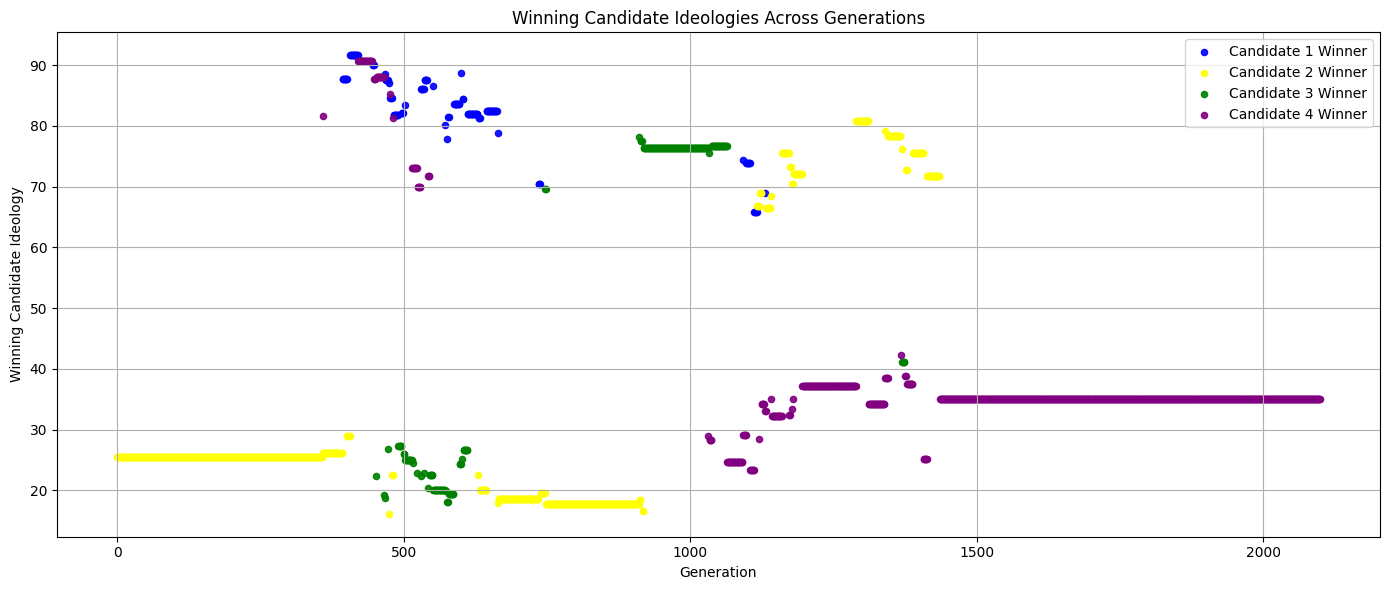

In [75]:
# Plot ideologies
colors = ['blue', 'yellow', 'green', 'purple']

plt.figure(figsize=(14, 6))
for idx in range(N_CANDIDATES):
    subset = df[(df["candidate_id"] == idx) & (df["is_winner"])]
    # subset = df[(df["candidate_id"] == idx) ]

    plt.scatter(subset["generation"], subset["policy"], color=colors[idx], alpha=0.9, s=20, label=f'Candidate {idx+1} Winner')

plt.xlabel("Generation")
plt.ylabel("Winning Candidate Ideology")
plt.title("Winning Candidate Ideologies Across Generations")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

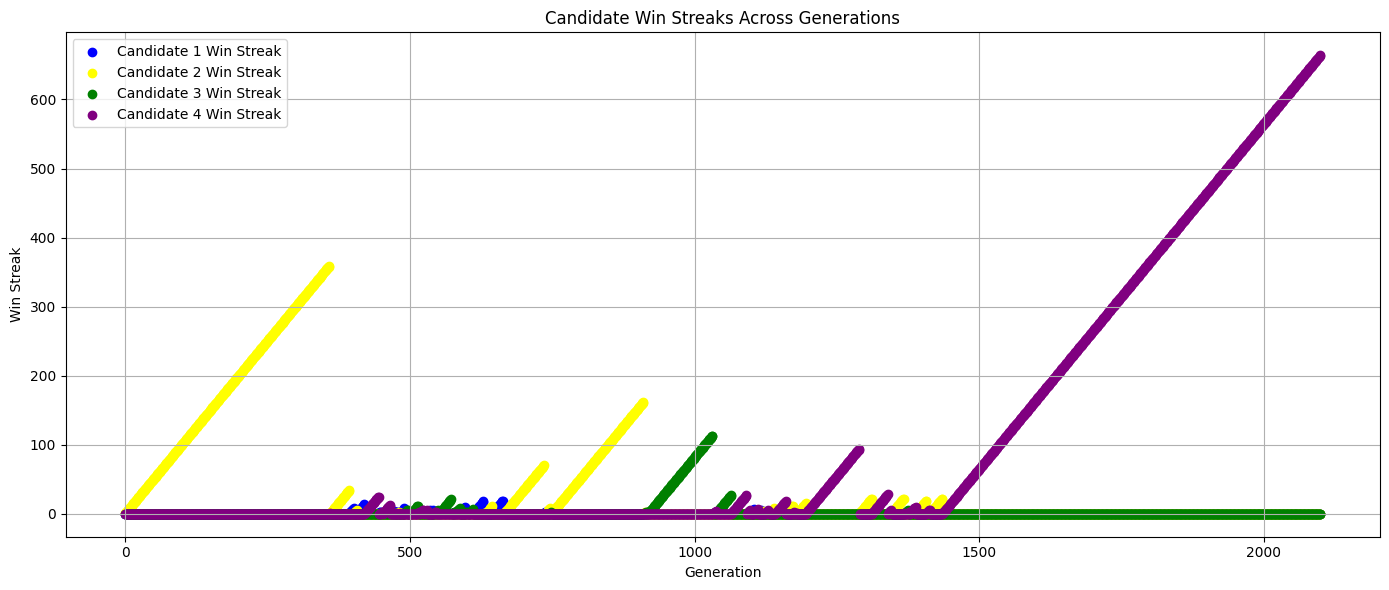

In [76]:
# Plot Win Streaks
plt.figure(figsize=(14, 6))
for idx in range(N_CANDIDATES):
    subset = df[df["candidate_id"] == idx]
    plt.scatter(subset["generation"], subset["win_streak"], label=f'Candidate {idx+1} Win Streak', color=colors[idx])

plt.xlabel("Generation")
plt.ylabel("Win Streak")
plt.title("Candidate Win Streaks Across Generations")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


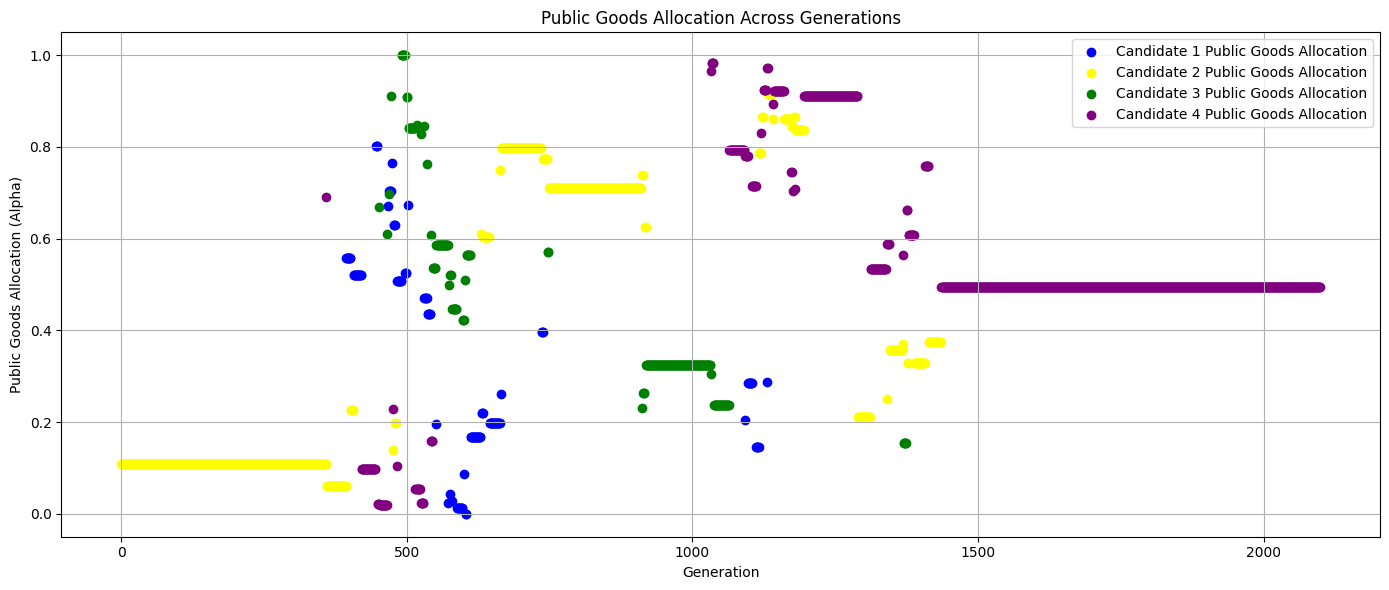

In [77]:
# Plot Public Goods Allocation
plt.figure(figsize=(14, 6))
for idx in range(N_CANDIDATES):
    # subset = df[df["candidate_id"] == idx]
    subset = df[(df["candidate_id"] == idx) & (df["is_winner"])]
    plt.scatter(subset["generation"], subset["alpha"], label=f'Candidate {idx+1} Public Goods Allocation', color=colors[idx])

plt.xlabel("Generation")
plt.ylabel("Public Goods Allocation (Alpha)")
plt.title("Public Goods Allocation Across Generations")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

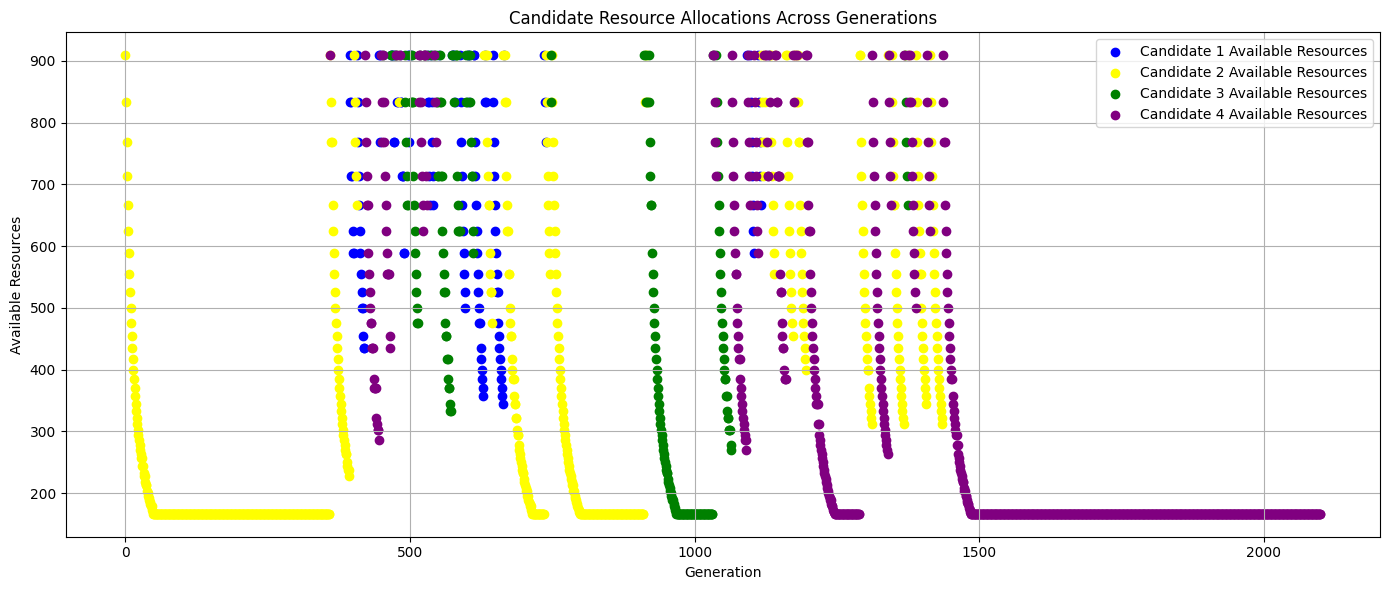

In [78]:
# Plot Resource Allocations
plt.figure(figsize=(14, 6))
for idx in range(N_CANDIDATES):
    # subset = df[df["candidate_id"] == idx]
    subset = df[(df["candidate_id"] == idx) & (df["is_winner"])]
    plt.scatter(subset["generation"], subset["available_resources"], label=f'Candidate {idx+1} Available Resources', color=colors[idx])

plt.xlabel("Generation")
plt.ylabel("Available Resources")
plt.title("Candidate Resource Allocations Across Generations")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [79]:
 # 1) Summarize winners
winners = (
        df[df['is_winner']]
        .loc[:, ['generation', 'candidate_id', 'win_streak', 'alpha', 'available_resources', 'votes']]
        .reset_index(drop=True)
    )

    # 2) Detect turnovers where previous streak ≥ 10
events = winners[
        (winners['candidate_id'] != winners['candidate_id'].shift(1)) &
        (winners['win_streak'].shift(1) >= 300)
    ]

if events.empty:
        print("No turnover after a 300+ win streak detected.")
else:
        print(f"Detected {len(events)} turnover(s) after 300+ win streak.\n")
        for _, ev in events.iterrows():
            gen = int(ev['generation'])
            prev = winners[winners['generation'] == gen - 1].iloc[0]
            print(f"🔄 Turnover at generation {gen}:")
            print(f"  • Previous Winner: Cand {prev['candidate_id']+1} "
                  f"(streak={int(prev['win_streak'])}, α={prev['alpha']:.2f}, "
                  f"res={prev['available_resources']:.1f}, votes={int(prev['votes'])})")
            print(f"  • New Winner:      Cand {ev['candidate_id']+1} "
                  f"(streak={int(ev['win_streak'])}, α={ev['alpha']:.2f}, "
                  f"res={ev['available_resources']:.1f}, votes={int(ev['votes'])})\n")

            # Reconstruct state at turnover
            sim2 = ElectionSim()
            for _ in range(gen):
                sim2.run_generation()

            # Snapshot of candidates
            snap = []
            for cid, c in enumerate(sim2.candidates):
                snap.append({
                    'Cand': cid+1,
                    'Policy': f"{c.policy:.1f}",
                    'α': f"{c.alpha:.2f}",
                    'Res': f"{c.available_resources:.1f}",
                    'Streak': c.win_streak,
                    'CoalSize': len(c.winning_coalition)
                })
            print("  Candidate snapshot at turnover:")
            print(pd.DataFrame(snap).to_string(index=False))

            # Vote counts at turnover
            # Recompute ballots
            ballots = []
            for v in sim2.voters:
                utils = [v.utility(c, len(c.winning_coalition)/N_VOTERS,
                                   v.inclusion(c, len(c.winning_coalition)/N_VOTERS))
                         for c in sim2.candidates]
                ballots.append(int(np.argmax(utils)))
            counts = np.bincount(ballots, minlength=N_CANDIDATES)
            print("\n  Votes per candidate at turnover:")
            for cid, count in enumerate(counts):
                print(f"    Cand {cid+1}: {count} votes")

            # Voter utilities
            recs = []
            for vid, v in enumerate(sim2.voters):
                for cid, c in enumerate(sim2.candidates):
                    p = len(c.winning_coalition)/N_VOTERS
                    inc = v.inclusion(c, p)
                    util = v.utility(c, p, inc)
                    recs.append({'Voter': vid+1, 'Cand': cid+1, 'U': util})
            util_df = pd.DataFrame(recs)
            avg_util = util_df.groupby('Cand')['U'].mean().reset_index()
            print("\n  Average voter utility per candidate at turnover:")
            print(avg_util.to_string(index=False))
            print("\n" + "-"*60 + "\n")


Detected 1 turnover(s) after 300+ win streak.

🔄 Turnover at generation 359:
  • Previous Winner: Cand 2.0 (streak=359, α=0.11, res=166.7, votes=35)
  • New Winner:      Cand 4.0 (streak=1, α=0.69, res=909.1, votes=39)

  Candidate snapshot at turnover:
 Cand Policy    α    Res  Streak  CoalSize
    1   43.7 0.52 1000.0       0         0
    2   81.2 0.31  166.7     166        34
    3   25.9 0.65 1000.0       0         0
    4    5.9 0.33 1000.0       0         0

  Votes per candidate at turnover:
    Cand 1: 24 votes
    Cand 2: 36 votes
    Cand 3: 20 votes
    Cand 4: 20 votes

  Average voter utility per candidate at turnover:
 Cand            U
    1  -887.368665
    2 -1997.019562
    3 -1344.911329
    4 -2624.643259

------------------------------------------------------------

